In [1]:
import pandas as pd 
import cv2
from sklearn.model_selection import train_test_split 
from keras.models import Sequential

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten
from utils import INPUT_SHAPE, batch_generator
import argparse
import os

from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_data(DATA_DIR,test_size=0.20):
    """
    Load training data and split it into training and validation set
    """
    #reads CSV file into a single dataframe variable
    data_df = pd.read_csv(os.path.join(os.getcwd(), DATA_DIR, 'driving_log.csv'), names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

    # store the camera images as our input data
    X = data_df[['center', 'left', 'right']].values
    
    #and our steering commands as our output data
    y = data_df['steering'].values

    #split the data into a training (80), testing(20), and validation set

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=test_size, random_state=0)

    return X_train, X_valid, y_train, y_valid

In [3]:
DATA_DIR = 'data'
X_train, X_valid, y_train, y_valid = load_data(DATA_DIR)

image_path = X_train

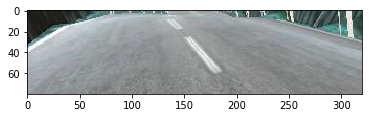

In [4]:
img = cv2.imread(X_train[3000,0])

img=img[55:-25, :, :]

INPUT_SHAPE = img.shape
plt.imshow(img)
plt.show()

In [5]:
def steer_net():
    """
    CNN architecture
    Image normalization to avoid saturation and make gradients work better.
    
    Convolution: 6x6, filter: 24, strides: 2x2, activation: ELU
    Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
    Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
    Drop out (0.5)
    Fully connected: neurons: 80, activation: ELU
    Fully connected: neurons: 40, activation: ELU
    Fully connected: neurons: 10, activation: ELU
    Fully connected: neurons: 1 (output)
    
    # the convolution layers are meant to handle feature engineering
    the fully connected layer for predicting the steering angle.
    dropout avoids overfitting
    ELU(Exponential linear unit) function takes care of the Vanishing gradient problem. 
    """
    keep_prob = 0.5
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
    model.add(Conv2D(24, (6, 6), activation='elu', strides=(2, 2)))
    model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(keep_prob))
    model.add(Flatten())
    model.add(Dense(80, activation='elu'))
    model.add(Dense(40, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    model.summary()

    return model

In [7]:
def train_model(model, X_train, X_valid, y_train, y_valid, learning_rate=1.0e-4, batch_size=100, data_dir='data', nb_epoch=10):
    """
    Train the model
    """
    #Saves the model after every epoch.
    #quantity to monitor, verbosity i.e logging mode (0 or 1), 
    #if save_best_only is true the latest best model according to the quantity monitored will not be overwritten.
    #mode: one of {auto, min, max}. If save_best_only=True, the decision to overwrite the current save file is
    # made based on either the maximization or the minimization of the monitored quantity. For val_acc, 
    #this should be max, for val_loss this should be min, etc. In auto mode, the direction is automatically
    # inferred from the name of the monitored quantity.
    checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')

    #calculate the difference between expected steering angle and actual steering angle
    #square the difference
    #add up all those differences for as many data points as we have
    #divide by the number of them
    #that value is our mean squared error! this is what we want to minimize via
    #gradient descent
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))

    #Fits the model on data generated batch-by-batch by a Python generator.

    #The generator is run in parallel to the model, for efficiency. 
    #For instance, this allows you to do real-time data augmentation on images on CPU in 
    #parallel to training your model on GPU.
    #so we reshape our data into their appropriate batches and train our model simulatenously
    model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                        samples_per_epoch=2000,
                        epochs=nb_epoch,
                        max_q_size=1,
                        validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                        validation_steps=len(X_valid),
                        callbacks=[checkpoint],
                        verbose=1)


In [ ]:
data = load_data(DATA_DIR)
#build model
model = steer_net()
#train model on data, it saves as model.h5 
train_model(model, *data)